<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI-Lab2021%5D%20Assignment%201%20OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment:
Preparation:
1. Checkout the notebook 0_Simple_NN.ipynb from Git, which describes how to
setup a simple feedforward network on some fake data. Try to understand
everything and execute the notebook. Ask on the chat if sth. is unclear.
2. Read through this blog post: https://nextjournal.com/gkoehler/pytorch-mnist
It shows how to work with data loaders, how to load the MNIST dataset and how
training is done in batches (using data loaders). 

Task:
1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog post.
2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in Simple_NN.ipynb).
For training on the MNIST dataset you need to change the following:
  - Adjust the size of the input layer to be able to take in the MNIST data (hint: you
must adjust the tensor format from the MNIST data into a flat structure).
  - Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.
3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog
but without the test loss).
4. Test the network on the MNIST test data and give out accuracy and loss.
5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not except too much improvement on
this small data set).
6. Repeat step 1. to 4. and see what happens when you try out:
  1. Two different hidden layer sizes.
  2. Using a normal softmax as activation function together with a CrossEntropyLoss.

In [1]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


# Parameter

In [2]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 #0.1 
momentum = 0.5
log_interval = 10

random_seed = 1
GPU_ON = True
torch.backends.cudnn.enabled = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
print(device)

GPU_time = 0
CPU_time = 0
network = None
optimizer = None

figures = []
results = []



cuda:0


# Download MNIST Dataset

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Explore Dataset

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

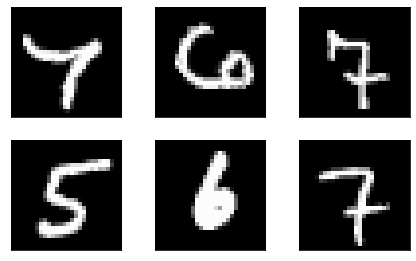

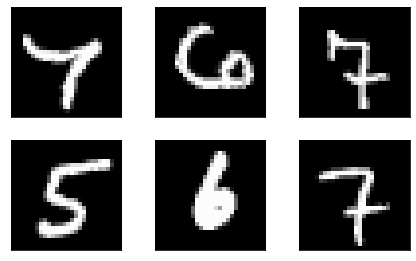

In [6]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Create Neural Network

In [7]:
class Net(nn.Module):
    def __init__(self, hidden_size, use_relu):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(28*28*1, hidden_size)
        self.output = torch.nn.Linear(hidden_size, 10)
        self.use_relu = use_relu

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = x.flatten(start_dim = 1)
        
        if self.use_relu:
          x = F.leaky_relu(self.hidden(x))#.clamp(min=0)
          x = F.log_softmax(self.output(x))
        else:
          x = F.softmax(self.hidden(x))
          x = self.output(x)
        return x

In [8]:
def defineNetwork(hidden_size, use_relu):
  global network
  network = Net(hidden_size, use_relu)
  if GPU_ON:
    network.cuda()
    
  global optimizer
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
def test(use_nll = True):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if GPU_ON:
        data = data.cuda()
        target = target.cuda()
      output = network(data)
      if use_nll:
        test_loss += F.nll_loss(output, target, size_average=False).item()
      else:
        test_loss += F.cross_entropy(output, target)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  return ('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  

In [10]:
def train(epoch,use_nll):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    if GPU_ON:
      data = data.cuda()
      target = target.cuda()
    output = network(data)
    if use_nll:
      loss = F.nll_loss(output, target)
    else:
      loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [11]:
def createPlot(activation_function, time, use_nll = True):
  temp = plt.figure()
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel("%s" % (network)+" "+ activation_function+ " "+time)
  if use_nll : 
    plt.ylabel('negative log likelihood loss')
  else:
    plt.ylabel('CrossEntropyLoss')
  plt.plot(train_counter, train_losses, color='blue')
  plt.close()
  return temp

# Training

##### Training GPU VS *CPU*

In [12]:

#CPU:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = False
defineNetwork(100, True)

CPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch, True)
  test()
results.append(test())


CPU_time = time.time() - CPU_time

plot = createPlot("Relu as Activation","CPU: %s seconds" % (CPU_time))
figures.append(plot)

#GPU
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch, True)
  test()
results.append(test())

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

print("--- CPU: %s seconds ---" % (CPU_time))
print("--- GPU: %s seconds ---" % (GPU_time))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.019227
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.029240
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.004685
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.012848
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.003825
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.006478
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.034272
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.008688
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.009789
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.008344
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.012254
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.007153
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.010281
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.009930
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.007790
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.013766
Train Epoch: 49 [46080/60000 (77%)]	Loss: 0.038589
Train Epoch: 49 [46720/60000 (78%)]	Loss: 0.002587
Train Epoch: 49

##### Training SoftMax 100 & 1000 Layers

In [13]:
#softmax 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, False)

GPU_time = time.time()

test(use_nll = False)
for epoch in range(1, n_epochs + 1):
  train(epoch, False)
  test(use_nll = False)
results.append(test(use_nll = False))


GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time), False)
figures.append(plot)

#softmax 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, False)

GPU_time = time.time()

test(use_nll = False)
for epoch in range(1, n_epochs + 1):
  train(epoch, False)
  test(use_nll = False)
results.append(test(use_nll = False))


GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time), False)
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.667243
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.857180
Train Epoch: 49 [35840/60000 (60%)]	Loss: 1.162014
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.832245
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.792179
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.769464
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.658134
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.710693
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.891316
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.784676
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.769935
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.972206
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.785280
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.775682
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.991006
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.730851
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.738629
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.913515
Train Epoch: 49

##### 100, 1000 & 10 000 Layers

In [14]:
#Relu 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch, True)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch, True)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 10000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(10000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch, True)
  test()
results.append(test())


GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.003802
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.010596
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.004865
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.007992
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.005887
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.001624
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.004281
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.006454
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.005483
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.014448
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.014215
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.004615
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.006035
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.009337
Train Epoch: 49 [43520/60000 (72%)]	Loss: 0.009557
Train Epoch: 49 [44160/60000 (74%)]	Loss: 0.008843
Train Epoch: 49 [44800/60000 (75%)]	Loss: 0.001902
Train Epoch: 49 [45440/60000 (76%)]	Loss: 0.004619
Train Epoch: 49

# Evaluation

##### GPU VS CPU


Test set: Avg. loss: 0.0754, Accuracy: 9793/10000 (98%)



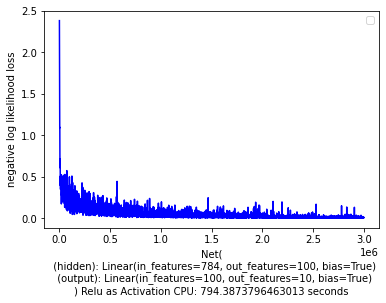

In [15]:
print(results[0])
figures[0]


Test set: Avg. loss: 0.0723, Accuracy: 9792/10000 (98%)



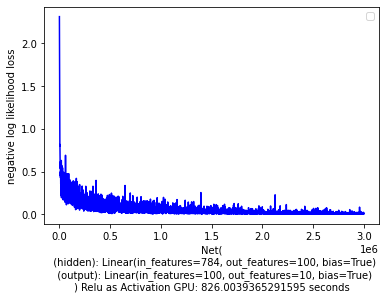

In [16]:
print(results[1])
figures[1]

##### Softmax


Test set: Avg. loss: 0.0008, Accuracy: 7533/10000 (75%)



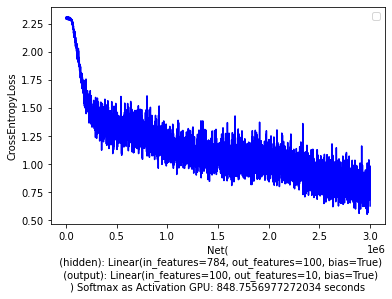

In [17]:
print(results[2])
figures[2]


Test set: Avg. loss: 0.0009, Accuracy: 6408/10000 (64%)



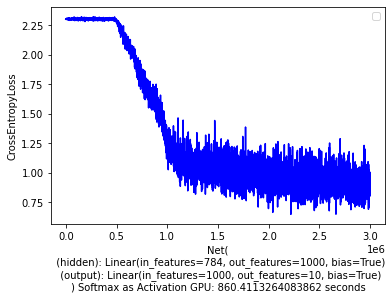

In [18]:
print(results[3])
figures[3]

Die Outputs der Softmax Funktion sind in Summe 1. So sind die Änderungen immer kleiner je mehr Neuronen es in einem Layer gibt. Folge: Das Netzwerk lernt langsammer als mit der Relu Funktion, welche die Änderungsrate nicht begrenzt.

Mögliche Lösung: Beim Verwenden von Softmax die Learning-Rate erhöhen. Dies erschwert aber die Suche nach einem lokalen Minimum.

##### Relu 100, 1000, 10 000


Test set: Avg. loss: 0.0695, Accuracy: 9816/10000 (98%)



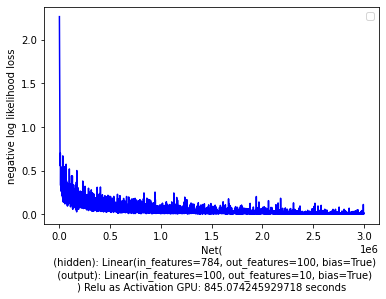

In [19]:
print(results[4])
figures[4]


Test set: Avg. loss: 0.0590, Accuracy: 9812/10000 (98%)



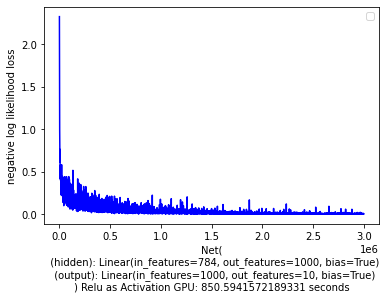

In [20]:
print(results[5])
figures[5]


Test set: Avg. loss: 0.0577, Accuracy: 9834/10000 (98%)



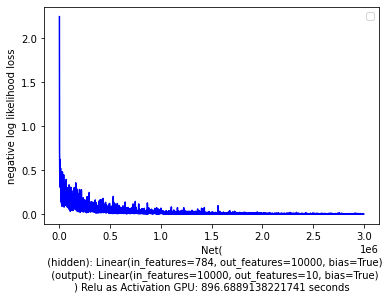

In [21]:
print(results[6])
figures[6]